In [5]:
%load_ext autoreload
%autoreload 2

from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates

from datetime import timedelta, date, datetime
import time
import os
import pickle

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df, scalar_or_vector_to_vector
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

today = datetime.today().date()
DATA_LAG_DAYS = 2
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = date(2023, 1, 1)
start_day = (start_date - date(2020, 10, 15)).days

# Forecast is one year ahead from today
forecast_lenght = 365 * 3
end_day = current_day + forecast_lenght
end_date = current_date + timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

auth_config='/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
setup_spacescope(auth_config)

class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

2023-01-01
2023-03-08
2026-03-07


In [10]:
# plot a column from the trajectory df
def plt_x(cil_df_summary, 
          quantity_to_plot='day_pledge_per_QAP', 
          scale_by=EIB, 
          smooth_by=1):  
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (8,5)

    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)][quantity_to_plot] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)][quantity_to_plot] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)][quantity_to_plot] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)][quantity_to_plot] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)][quantity_to_plot] / scale_by
    
    plt.fill_between(dates_, q05_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    plt.fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    plt.plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[0][2], lw=2, label='Median')

    plt.xticks(rotation = 30)
    plt.title(f"{quantity_to_plot}")
    plt.legend(loc=2)
    plt.show()
    
# baseline crossing plots
def plt_blc(cil_df_summary, 
            quantity_to_plot='day_pledge_per_QAP', 
            scale_by=EIB, 
            smooth_by=1):
    # function to plot baseline crossing
    
    cil_df_summary = cil_df_summary[cil_df_summary['date'] <= pd.to_datetime(date(2024, 12, 1))]
    
    # define plot settings and palette
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (18,18)
    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]
    fig, axs = plt.subplots(4,2, constrained_layout=True)
    
    rolling_fn = lambda x: np.nanmedian(x)
    
    # select plotting data
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_RBP'] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_RBP'] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_RBP'] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_RBP'] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_RBP'] / scale_by
    # plot RBP predictions
    axs[0,0].fill_between(dates_, q5_t.rolling(smooth_by).apply(rolling_fn), q95_t.rolling(smooth_by).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='RBP Q90')
    axs[0,0].fill_between(dates_, q25_t.rolling(smooth_by).apply(rolling_fn), q75_t.rolling(smooth_by).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='RBP Q50')
    axs[0,0].plot(dates_, q50_t.rolling(smooth_by).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='RBP Median')
     # select plotting data
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_QAP'] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_QAP'] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_QAP'] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_QAP'] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_QAP'] / scale_by
# #     # plot QAP predictions
#     axs[0,0].fill_between(dates_, q5_t.rolling(smooth_by).median(), q95_t.rolling(smooth_by).median(), 
#                      alpha=0.5, color=colors_[1][0], label='QAP Q90')
#     axs[0,0].fill_between(dates_, q25_t.rolling(smooth_by).median(), q75_t.rolling(smooth_by).median(), 
#                      alpha=0.65, color=colors_[1][1], label='QAP Q50')
#     axs[0,0].plot(dates_, q50_t.rolling(smooth_by).median(), alpha=1, color=colors_[1][2], lw=2, label='QAP Median')
    
    # plot baseline
    axs[0,0].plot(dates_, baseline[0:len(dates_)], c='darkblue', label='baseline target')  
    axs[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs[0,0].tick_params(axis='x', labelrotation = 30)
    axs[0,0].legend(loc='upper right')
    axs[0,0].set_title('Baseline crossing')
    axs[0,0].set_ylabel('EiB')
    axs[0,0].set_ylim(10,20)
    axs[0,0].set_xlim(dates_[0],datetime.date(2023, 6, 6))
    
    # plot baseline crossing PDF
    axs[0,1].hist(date_cross_samples,
                bins=500,
                density=True,
                label='Baseline crossing PDF', color=colors_[0][0])
    cross_q50 = pd.Series(date_cross_samples).quantile(0.5, interpolation="midpoint")
    axs[0,1].axvline(cross_q50, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Median {str(cross_q50)}')
    cross_q95 = pd.Series(date_cross_samples).quantile(0.95, interpolation="midpoint")
    axs[0,1].axvline(cross_q95, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q95 {str(cross_q95)}')
    cross_q5 = pd.Series(date_cross_samples).quantile(0.05, interpolation="midpoint")
    axs[0,1].axvline(cross_q5, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q5 {str(cross_q5)}')
#     axs[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs[0,1].set_xlim(cross_q5-timedelta(days=30), cross_q95+timedelta(days=30))
    axs[0,1].tick_params(axis='x', labelrotation = 30)
    axs[0,1].set_title('Crossing empirical PDF')
    axs[0,1].legend(loc='upper right')

    # plot pledge per sector
#     w = 60
    w = 7
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_pledge_per_QAP'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_pledge_per_QAP']
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_pledge_per_QAP']
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_pledge_per_QAP']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_pledge_per_QAP']
    print(len(dates_), len(q05_t), len(q25_t), len(q50_t), len(q75_t), len(q95_t))
    print(len(q05_t.rolling(w).apply(rolling_fn)),
          len(q25_t.rolling(w).apply(rolling_fn)),
          len(q50_t.rolling(w).apply(rolling_fn)),
          len(q75_t.rolling(w).apply(rolling_fn)),
          len(q95_t.rolling(w).apply(rolling_fn)))
    print(len(np.where(np.isnan(q05_t.rolling(w).apply(rolling_fn)))[0]),
          len(np.where(np.isnan(q25_t.rolling(w).apply(rolling_fn)))[0]),
          len(np.where(np.isnan(q50_t.rolling(w).apply(rolling_fn)))[0]),
          len(np.where(np.isnan(q75_t.rolling(w).apply(rolling_fn)))[0]),
          len(np.where(np.isnan(q95_t.rolling(w).apply(rolling_fn)))[0]))
    axs[1,0].fill_between(dates_, q05_t.rolling(w).apply(rolling_fn), q95_t.rolling(w).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[1,0].fill_between(dates_, q25_t.rolling(w).apply(rolling_fn), q75_t.rolling(w).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[1,0].plot(dates_, q50_t.rolling(w).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[1,0].tick_params(axis='x', labelrotation = 30)
    axs[1,0].set_title('Pledge per 32 GiB')
    axs[1,0].legend(loc='upper right')
    axs[1,0].set_ylabel('FIL')
    axs[1,0].set_ylim(0,0.5)
    
    # plot network reward
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_network_reward'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_network_reward'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_network_reward'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_network_reward']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_network_reward']
    axs[1,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[1,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[1,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[1,1].tick_params(axis='x', labelrotation = 30)
    axs[1,1].set_title('Minting')
    axs[1,1].legend(loc='upper right')
    axs[1,1].set_ylabel('FIL/day')
    
    # plot roi
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['1y_sector_roi'] * 100
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['1y_sector_roi']  * 100
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['1y_sector_roi'] * 100
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['1y_sector_roi'] * 100
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['1y_sector_roi'] * 100
    axs[2,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[2,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[2,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[2,1].tick_params(axis='x', labelrotation = 30)
    axs[2,1].set_title('1y sector ROI')
    axs[2,1].legend(loc='upper right')
    axs[2,1].set_ylabel('%')
    axs[2,1].set_ylim(0,)
    xt = axs[2,1].get_xticks()
    xl = axs[2,1].get_xlim()
    
    # plot daily locked pledge
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_locked_pledge'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_locked_pledge'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_locked_pledge'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_locked_pledge']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_locked_pledge']
    axs[2,0].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[2,0].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).median(), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[2,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[2,0].tick_params(axis='x', labelrotation = 30)
    axs[2,0].set_title('Daily locked pledge')
    axs[2,0].legend(loc='upper right')
    axs[2,0].set_ylabel('FIL/day')
    
    # plot network locked
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_locked'] 
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_locked'] 
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_locked'] 
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_locked']
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_locked']
    axs[3,0].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[3,0].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[3,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[3,0].tick_params(axis='x', labelrotation = 30)
    axs[3,0].set_title('Network locked')
    axs[3,0].legend(loc='upper right')
    axs[3,0].set_ylabel('FIL')
    
    # plot lock / supply
    cil_df_summary['locked_over_supply'] = cil_df_summary['network_locked'] / cil_df_summary['circ_supply']
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['locked_over_supply'] * 100
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['locked_over_supply'] * 100
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['locked_over_supply'] * 100
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['locked_over_supply'] * 100
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['locked_over_supply'] * 100
    axs[3,1].fill_between(dates_, q05_t.rolling(7).apply(rolling_fn), q95_t.rolling(7).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='Q5-Q95')
    axs[3,1].fill_between(dates_, q25_t.rolling(7).apply(rolling_fn), q75_t.rolling(7).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='Q25-Q75')
    axs[3,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='Median')
    axs[3,1].tick_params(axis='x', labelrotation = 30)
    axs[3,1].set_title('Locked / Supply')
    axs[3,1].legend(loc='upper right')
    axs[3,1].set_ylabel('%')
    
    plt.show()

In [17]:
# simulation
# seperating from the expensive MCMC loop
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

# def get_historical_renewal_rate(current_date,start_date)->np.array:
#     df_renewal_rate_orig = pd.read_csv('./offline_info/Scheduled_Expiration_by_Date_Breakdown_in_FIL.csv', 
#                                        parse_dates=['stateTime'])
#     df_renewal_rate = df_renewal_rate_orig.copy()
#     df_renewal_rate['Renewal_Rate'] = df_renewal_rate['Extend'] / (df_renewal_rate['Extend'] 
#                                  + df_renewal_rate['Expired']
#                                  + df_renewal_rate['Potential Expire'])
#     df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime <= str(current_date)]
#     df_renewal_rate = df_renewal_rate[df_renewal_rate.stateTime >= str(start_date)]
#     historical_renewal_rate = df_renewal_rate.Renewal_Rate.values
#     return historical_renewal_rate

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
    return df_out

def run_sim(fil_plus_rate:Union[float, np.array], 
            rb_onboard_power:[float, np.array], 
            renewal_rate:[float, np.array])->pd.DataFrame():
    future_renewal_rate = scalar_or_vector_to_vector(renewal_rate, forecast_lenght)
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        future_renewal_rate,
        fil_plus_rate,
        duration,
        forecast_lenght,
        qap_method='basic'
    )
    
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )

    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec
    )
    
    return cil_df

# sampling
def get_uniform_samples(central_estimate:float, 
                UR:float = 0.5, 
                n_samples:int = 100,
                key:int = 666,)->np.array:
    rng_key = random.split(random.PRNGKey(key))
    samples = dist.Uniform(central_estimate*(1-UR),
                           central_estimate*(1+UR)).expand([n_samples]).sample(rng_key[0])
    return np.array(samples)

def generate_prior_samples(n_samples=10, UR=0.5, 
                           fil_plus_rate_central=0.25, 
                           rb_onboard_power_central=8, 
                           renewal_rate_central=0.5)->pd.DataFrame:
    fil_plus_rate_samples = get_uniform_samples(central_estimate=fil_plus_rate_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    rb_onboard_power_samples = get_uniform_samples(central_estimate=rb_onboard_power_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    renewal_rate_samples = get_uniform_samples(central_estimate=renewal_rate_central, 
                                        UR=UR, 
                                        n_samples=n_samples)
    samples_df = pd.DataFrame({'fil_plus_rate': fil_plus_rate_samples,
                               'rb_onboard_power': rb_onboard_power_samples,
                               'renewal_rate': renewal_rate_samples})
    return samples_df

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

def run_sim_mc(samples_df)->pd.DataFrame:
    cil_df_i, cil_df = pd.DataFrame(), pd.DataFrame()
    for i in tqdm(samples_df.index):
        fil_plus_rate = samples_df['fil_plus_rate'].iloc[i]
        if isinstance(fil_plus_rate, ArrayWrapperObj):
            fil_plus_rate = fil_plus_rate.get()
        rb_onboard_power = samples_df['rb_onboard_power'].iloc[i]
        if isinstance(rb_onboard_power, ArrayWrapperObj):
            rb_onboard_power = rb_onboard_power.get()
        renewal_rate = samples_df['renewal_rate'].iloc[i]
        if isinstance(renewal_rate, ArrayWrapperObj):
            renewal_rate = renewal_rate.get()
        cil_df_i = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate)

        cil_df_i['iter'] = i
        cil_df_i['fil_plus_rate'] = ArrayWrapperObj(fil_plus_rate)
        cil_df_i['rb_onboard_power'] = ArrayWrapperObj(rb_onboard_power)
        cil_df_i['renewal_rate'] = ArrayWrapperObj(renewal_rate)
        cil_df = cil_df.append(cil_df_i)

    cil_df.index = cil_df.date
    cil_df.drop('date',axis=1,inplace=True)
    return cil_df

# baseline storage function
def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# summary statistics of trajectory dynamics
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def find_QAP_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_QAP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_QAP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing


# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df[['iter','day_rewards_per_sector']].groupby('iter').rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

In [12]:
# separate expensive preprocessing from MCMC loop
rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
vest_df = compute_vesting_trajectory_df(start_date, end_date)
# historical_renewal_rate = get_historical_renewal_rate(current_date-timedelta(days=1),start_date)
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)

In [33]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 100
seasonality_mcmc = 2000
num_chains_mcmc = 2

rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
    generate_mcmc_forecast_samples(mcmc_train_start_date,
                                   mcmc_train_end_date,
                                   forecast_lenght,
                                   num_warmup_mcmc,
                                   num_samples_mcmc,
                                   seasonality_mcmc,
                                   num_chains_mcmc)

Forecasting Onboarding Power


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.04      0.03     -0.03     -0.09     -0.00     73.49      0.99
       init_s[0]     -0.90     12.35     -0.49    -25.93     10.99    196.78      1.00
       init_s[1]     -0.45      0.26     -0.45     -0.87     -0.08    153.54      1.01
       init_s[2]     -0.55      0.33     -0.56     -1.01      0.04    122.92      1.00
       init_s[3]     -0.34      0.34     -0.30     -0.84      0.19     77.51      1.03
       init_s[4]      0.27      0.36      0.29     -0.27      0.78    109.36      1.01
       init_s[5]      0.45      0.42      0.49     -0.25      1.06     62.85      1.02
       init_s[6]      0.88      0.42      0.91      0.30      1.54     37.72      1.05
       init_s[7]      1.51      0.44      1.50      0.89      2.25     41.92      1.05
       init_s[8]      1.36      0.49      1.37      0.70      2.29     43.64      1.05
       init_s[9]      0.99      0.53      

Forecasting Renewal Rate


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      1.07      0.72      0.87      0.10      2.05     49.10      1.03
       init_s[0]      3.18     19.11      3.57    -28.90     29.20    210.82      0.99
       init_s[1]      0.29      0.81      0.46     -1.02      1.30      3.66      1.24
       init_s[2]      5.69      0.77      5.66      4.88      6.78     32.30      1.03
       init_s[3]      0.39      0.90      0.38     -0.84      1.50      3.60      1.18
       init_s[4]     -1.39      0.87     -1.27     -2.77     -0.09      5.10      1.17
       init_s[5]     -3.86      0.67     -3.95     -4.94     -2.82     53.21      1.03
       init_s[6]      1.12      0.74      1.16      0.05      2.43     13.72      1.09
       init_s[7]      0.30      0.78      0.20     -0.65      1.64     16.52      1.06
       init_s[8]      3.41      0.88      3.52      2.14      4.74     10.56      1.12
       init_s[9]     -2.62      0.70     -

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.06      0.32      0.04     -0.49      0.61    177.27      1.00
       init_s[0]      2.19     31.75      0.22    -24.05     39.19    125.70      1.00
       init_s[1]     -1.07      4.46     -2.34     -5.80      7.92     31.16      1.09
       init_s[2]     -3.76      4.37     -3.97    -10.12      3.59     63.51      1.04
       init_s[3]     -1.50      2.35     -1.13     -5.50      1.85     82.18      1.03
       init_s[4]     -1.97      2.17     -1.57     -5.65      0.92    108.49      1.01
       init_s[5]     -2.75      2.16     -2.66     -6.21      0.43    120.30      1.00
       init_s[6]     -1.65      1.83     -1.25     -3.98      1.30    105.42      1.01
       init_s[7]     -1.97      1.54     -1.79     -4.36      0.78    174.12      1.01
       init_s[8]     -1.93      1.45     -2.00     -4.13      0.51    232.70      1.00
       init_s[9]      0.06      1.52     -

Forecasting FIL+ Rate


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.02      0.02      0.02     -0.00      0.05    163.51      1.00
       init_s[0]     -0.01      0.89     -0.03     -1.40      1.47    113.09      1.00
       init_s[1]     -0.02      0.15     -0.02     -0.22      0.25     81.80      1.01
       init_s[2]      0.03      0.16      0.04     -0.19      0.33    123.76      1.01
       init_s[3]      0.01      0.16      0.03     -0.25      0.23     75.97      1.02
       init_s[4]     -0.09      0.16     -0.09     -0.31      0.18    121.03      1.01
       init_s[5]     -0.08      0.18     -0.07     -0.36      0.19    144.60      1.00
       init_s[6]      0.13      0.18      0.12     -0.10      0.45    173.57      1.00
       init_s[7]      0.13      0.18      0.12     -0.13      0.46    178.01      0.99
       init_s[8]      0.06      0.17      0.05     -0.18      0.37    129.13      1.00
       init_s[9]     -0.14      0.17     -

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.03      0.03     -0.02     -0.07      0.01    123.96      1.00
       init_s[0]      0.27     20.45     -0.50    -20.92     14.45    251.96      0.99
       init_s[1]     -0.47      0.39     -0.42     -0.99      0.14     80.35      1.00
       init_s[2]     -0.62      0.43     -0.62     -1.30      0.06     93.22      1.01
       init_s[3]     -0.41      0.44     -0.42     -1.02      0.39    121.84      1.02
       init_s[4]      0.24      0.54      0.25     -0.63      1.01     63.53      1.02
       init_s[5]      0.45      0.57      0.49     -0.40      1.40     99.83      1.01
       init_s[6]      0.59      0.57      0.61     -0.25      1.48     99.35      1.00
       init_s[7]      1.20      0.58      1.22      0.35      2.05     89.97      1.02
       init_s[8]      1.13      0.51      1.12      0.20      1.93     99.37      1.01
       init_s[9]      1.00      0.67      

In [34]:
df_mcmc = pd.DataFrame(columns=['rb_onboard_power', 'renewal_rate', 'fil_plus_rate'])
df_mcmc['rb_onboard_power'] = df_mcmc['rb_onboard_power'].astype(object)
df_mcmc['renewal_rate'] = df_mcmc['renewal_rate'].astype(object)
df_mcmc['fil_plus_rate'] = df_mcmc['fil_plus_rate'].astype(object)
num_mcmc_samps = rb_onboard_power_pred.shape[0]
for i in range(num_mcmc_samps):
    df_row = pd.DataFrame({
        'rb_onboard_power': ArrayWrapperObj(np.asarray(rb_onboard_power_pred[i,:])),
        'renewal_rate': ArrayWrapperObj(np.asarray(renewal_rate_pred[i,:])),
        'fil_plus_rate': ArrayWrapperObj(np.asarray(filplus_rate_pred[i,:]))
#         'fil_plus_rate': ArrayWrapperObj(np.ones(forecast_lenght)*0.1)
    }, index=[0])
    df_mcmc = pd.concat([df_mcmc, df_row], ignore_index=True)

In [35]:
cil_mcmc_df = run_sim_mc(df_mcmc)

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
offline_info_dir = 'offline_info'
os.makedirs(offline_info_dir, exist_ok=True)
save_info = {}
save_info['cil_mcmc_df'] = cil_mcmc_df
save_info['df_mcmc'] = df_mcmc
with open(os.path.join(offline_info_dir, 'qap_crossing.pkl'), 'wb') as f:
    pickle.dump(save_info, f)

In [49]:
with open(os.path.join(offline_info_dir, 'qap_crossing.pkl'), 'rb') as f:
    results = pickle.load(f)
    cil_mcmc_df = results['cil_mcmc_df']
    df_mcmc = results['df_mcmc']

In [50]:
# find baseine storage function and crossings
cil_mcmc_mean = cil_mcmc_df.groupby('date').mean()
baseline = baseline_storage(cil_mcmc_mean.days * EPOCH_PER_DAY)
date_cross_samples = find_QAP_crossings(cil_mcmc_df)

# add ROI & summary
cil_mcmc_df_roi = add_generated_quantities(cil_mcmc_df)
cil_mcmc_df_summary = get_df_summary(cil_mcmc_df_roi)

In [57]:
max(date_cross_samples)

datetime.date(2025, 10, 11)

In [52]:
# plt_blc(cil_mcmc_df_summary, 
#           quantity_to_plot='network_RBP', 
#           scale_by=EIB)

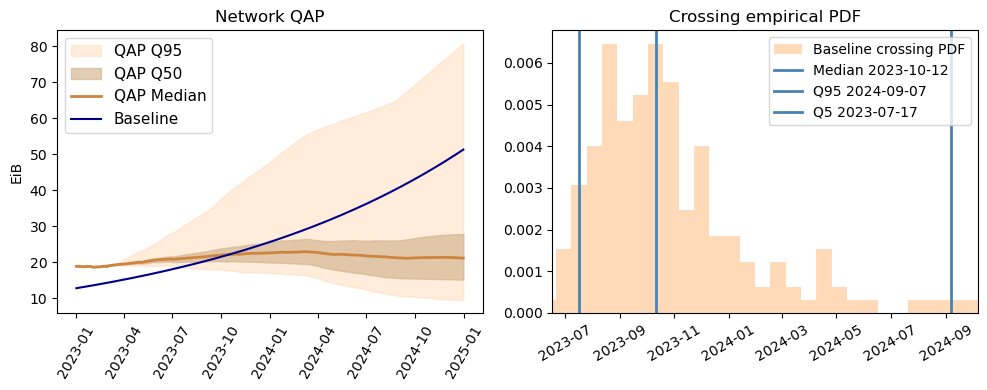

In [61]:
output_dir='/Users/kiran/Documents/hackmd/qap_baseline_crossing/'
os.makedirs(output_dir, exist_ok=True)

def save_blc_plot(cil_df_summary, 
                  quantity_to_plot='day_pledge_per_QAP', 
                  scale_by=EIB, 
                  smooth_by=1):
    # function to plot baseline crossing
    
    # define plot settings and palette
#     plt.rcParams.update({'font.size': 18})
#     plt.rcParams["figure.figsize"] = (18,18)
    colors_ = [['peachpuff', 'tan', 'peru'], 
               ['powderblue', 'skyblue', 'steelblue'], 
               ['lightsalmon', 'tomato', 'firebrick']]

    fig, axs = plt.subplots(1,2, figsize=(10,4))

    rolling_fn = lambda x: np.nanmedian(x)
    
    cil_df_summary = cil_df_summary[pd.to_datetime(cil_df_summary['date']) <= pd.to_datetime(date(2024, 12, 31))]
    plt_baseline = baseline[baseline.index <= pd.to_datetime(date(2024, 12, 31))]
    
    # select plotting data
    dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
    q5_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_QAP'] / scale_by
    q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_QAP'] / scale_by
    q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_QAP'] / scale_by
    q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_QAP'] / scale_by
    q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_QAP'] / scale_by
    # plot RBP predictions
    axs[0].fill_between(dates_, q5_t.rolling(smooth_by).apply(rolling_fn), q95_t.rolling(smooth_by).apply(rolling_fn), 
                     alpha=0.5, color=colors_[0][0], label='QAP Q95')
    axs[0].fill_between(dates_, q25_t.rolling(smooth_by).apply(rolling_fn), q75_t.rolling(smooth_by).apply(rolling_fn), 
                     alpha=0.65, color=colors_[0][1], label='QAP Q50')
    axs[0].plot(dates_, q50_t.rolling(smooth_by).apply(rolling_fn), alpha=1, color=colors_[0][2], lw=2, label='QAP Median')
    
    # plot baseline
    axs[0].plot(dates_, plt_baseline, c='darkblue', label='Baseline')  
    axs[0].legend(loc='upper left', fontsize=11)
    axs[0].set_title('Network QAP')
    axs[0].set_ylabel('EiB')
    axs[0].tick_params(axis='x', labelrotation = 60)
    
    axs[1].hist(date_cross_samples,
                bins=50,
                density=True,
                label='Baseline crossing PDF', color=colors_[0][0])
    cross_q50 = pd.Series(date_cross_samples).quantile(0.5, interpolation="midpoint")
    axs[1].axvline(cross_q50, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Median {str(cross_q50)}')
    cross_q95 = pd.Series(date_cross_samples).quantile(0.95, interpolation="midpoint")
    axs[1].axvline(cross_q95, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q95 {str(cross_q95)}')
    cross_q5 = pd.Series(date_cross_samples).quantile(0.05, interpolation="midpoint")
    axs[1].axvline(cross_q5, color=colors_[1][2], linestyle='-', 
                   lw=2, alpha=1, label=f'Q5 {str(cross_q5)}')
    axs[1].set_xlim(cross_q5-timedelta(days=30), cross_q95+timedelta(days=30))
    axs[1].tick_params(axis='x', labelrotation = 30)
    axs[1].set_title('Crossing empirical PDF')
    axs[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'qap_blc.png'))

save_blc_plot(cil_mcmc_df_summary, 
              quantity_to_plot='network_RBP', 
              scale_by=EIB)